In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory  # Import here
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Specify the path to your zipped dataset
dataset_zip_path = "C:/Users/sonic/Desktop/NTU Notes PC/Y4/Y4S1/IE4483 - Art Intell & Data Mining/Mini Project/Datasets/datasets.zip"  # Replace with your actual path

In [4]:
# Extract the dataset
temp_dir = "extracted_data"  
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

In [5]:
# Define training, validation, and test directories
train_dir = 'extracted_data/datasets/train'
val_dir = 'extracted_data/datasets/val'
test_dir = 'extracted_data/datasets/test'

In [6]:
# Create datasets
train_datagen = image_dataset_from_directory(
    train_dir, image_size=(150, 150), subset='training', seed=1, validation_split=0.1, batch_size=32
)

val_datagen = image_dataset_from_directory(
    val_dir, image_size=(150, 150), subset='validation', seed=1, validation_split=0.1, batch_size=32
)

Found 20000 files belonging to 2 classes.
Using 18000 files for training.
Found 5000 files belonging to 2 classes.
Using 500 files for validation.


In [7]:
# Normalize the datasets
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_datagen.map(normalize_image)
val_dataset = val_datagen.map(normalize_image)

In [8]:
# Load the pre-trained ResNet50 model without the top layer (include_top=False)
# Modify the input_shape to match the dimensions (150x150x3) of your dataset
resnet_model = Sequential()
pretrained_resnet = ResNet50(include_top=False, input_shape=(150, 150, 3), pooling='avg', weights='imagenet')

In [9]:
# Unfreeze all layers of the pre-trained model to fine-tune on Cats vs. Dogs
for layer in pretrained_resnet.layers:
    layer.trainable = True

In [10]:
# Add the pre-trained model and additional layers for binary classification
resnet_model.add(pretrained_resnet)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dropout(0.5))
resnet_model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification for Cats and Dogs

In [11]:
# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
# Train the model
epochs = 10
history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/10
563/563 [==============================] - 88s 125ms/step - loss: 0.1192 - accuracy: 0.9532 - val_loss: 0.5728 - val_accuracy: 0.6920
Epoch 2/10
563/563 [==============================] - 67s 120ms/step - loss: 0.0365 - accuracy: 0.9865 - val_loss: 0.0931 - val_accuracy: 0.9640
Epoch 3/10
563/563 [==============================] - 69s 123ms/step - loss: 0.0232 - accuracy: 0.9918 - val_loss: 0.3181 - val_accuracy: 0.9400
Epoch 4/10
563/563 [==============================] - 70s 124ms/step - loss: 0.0214 - accuracy: 0.9929 - val_loss: 0.0444 - val_accuracy: 0.9840
Epoch 5/10
563/563 [==============================] - 71s 125ms/step - loss: 0.0145 - accuracy: 0.9952 - val_loss: 0.2108 - val_accuracy: 0.9480
Epoch 6/10
563/563 [==============================] - 70s 124ms/step - loss: 0.0189 - accuracy: 0.9936 - val_loss: 0.1657 - val_accuracy: 0.9480
Epoch 7/10
563/563 [==============================] - 71s 125ms/step - loss: 0.0146 - accuracy: 0.9949 - val_loss: 0.0713 - val_ac

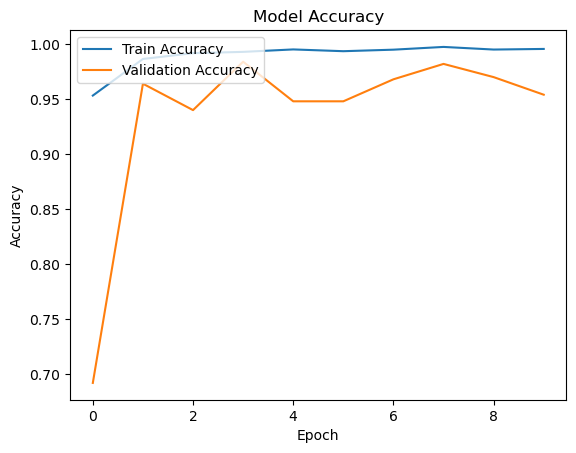

In [13]:
# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [15]:
# Test Data Prediction
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory='extracted_data/datasets',
    target_size=(150, 150),
    batch_size=32,
    class_mode=None,
    shuffle=False,
    classes=['test']
)

Found 500 images belonging to 1 classes.


In [16]:
# Collect predictions
predictions = []
test_ids = [os.path.basename(filepath) for filepath in test_generator.filepaths]

In [17]:
# Run predictions on the test dataset
for batch in test_generator:
    batch_predictions = resnet_model.predict(batch)
    predictions.extend(batch_predictions)
    if len(predictions) >= test_generator.samples:
        break

In [18]:
# Map predictions to "Cat" or "Dog"
predicted_labels_list = ['Dog' if pred >= 0.5 else 'Cat' for pred in predictions]

In [19]:
# Save predictions to Excel
test_df = pd.DataFrame({'Image ID': test_ids, 'Predicted': predicted_labels_list})

In [20]:
# Save results to Excel file
output_file = 'predictions_output_resnet50.xlsx'  # Change filename to avoid overwriting
with pd.ExcelWriter(output_file) as writer:
    test_df.to_excel(writer, sheet_name='Test', index=False)

print(f"Test results saved to {output_file}")

Test results saved to predictions_output_resnet50.xlsx


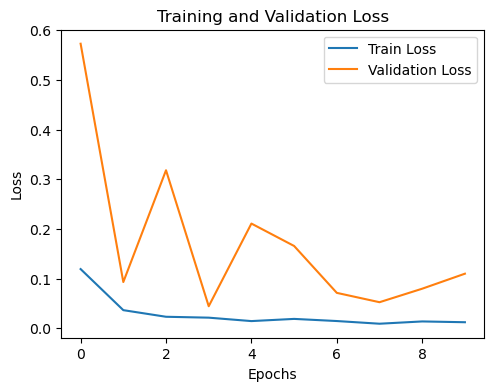

In [2]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot([0.1192,0.0365,0.0232,0.0214,0.0145,0.0189,0.0146,0.0092,0.0138,0.0122], label='Train Loss')
plt.plot([0.5728,0.0931,0.3181,0.0444,0.2108,0.1657,0.0713,0.0525,0.0797,0.1099], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()